In [2]:
# The data we need
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

from numpy import ndenumerate

#Other shit

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter,
import matplotlib.ticker as ticker
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

import seaborn as sns
import autograd.numpy as np
from autograd import grad, elementwise_grad
import pandas as pd
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.utils import resample
from sklearn.model_selection import KFold, cross_val_score
plt.rcParams['font.size'] = 14


In [3]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)

    return term1 + term2 + term3 + term4 


# Defining the R2 function, from lecture notes
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)


# Defining the Mean square error, from lecture notes
def MSE(y,ytilde):
    n = len(y)
    return 1/n * np.sum(np.abs(y-ytilde)**2)



# Creating the design matrix, from lecture notes
def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X


# making the OCS regression
def OLSmethod(X,z):
    return np.linalg.pinv(X.T @ X) @ X.T @ z

#from lecturenotes
def gradientOLS(X,z,beta):
    n=len(z)
    return 2.0/n*X.T @ ((X @ beta)-z)




def StocGradOLS(numberMinibach,numEpochs,X,z,eta):
    betaOLS_stoc = np.random.randn(X.shape[1],1)
    MiniBachSize = int(X.shape[0]/numberMinibach)
    ##### For fixed learning rate coment in the last learningrate
    t_0 = 2 #
    t_1 = 2/(eta) #
    for i in range(numEpochs):
        for j in range(numberMinibach):
            miniBach = np.random.randint(numberMinibach)

            miniBachMin, miniBachMax = MiniBachSize * miniBach,(MiniBachSize) * (miniBach+1)
            t = i*numberMinibach + j #
            learningrate = t_0/(t_1 +t) #
            #learningrate = eta
            betaOLS_stoc -= learningrate *gradientOLS(X_train[miniBachMin: miniBachMax],z_train[miniBachMin:miniBachMax],betaOLS_stoc)
    return betaOLS_stoc


def sigmoid(x):
    return 1/(1+np.exp(-x))
def logistic_reg(x,w):
    return sigmoid(np.dot(x,w))


# Need to take a look at this later
def logistic_cost_deriv(x,w,y,lam):
   
    a1 = np.sum((1/(1+np.exp(-x@w)) -y)@x) + 2 *lam*np.sum(np.abs(w))
    return a1

def logistic_cost(x,w,t,_lambda = 0):
    pred = logistic_reg(x,w)
    cost_inner = np.log(pred) * t + np.log(1 - pred) * (1 - t)
    
    #return -(np.sum(np.log(cost_inner)) + _lambda*np.sum(w**2))
    return -np.sum((cost_inner)) + _lambda*np.sum(w**2)
    



def StocGradLogic(numberMinibach, numEpochs, X, z, eta,_lambda = 0):
    # Defining weights
    param = np.random.randn(X.shape[1],1)*0.01
    not_nan = False
    
    
    MiniBachSize = int(X.shape[0] / numberMinibach)
    t_0 = 2
    t_1 = 2 / (eta)

    gradient = elementwise_grad(logistic_cost, 1)

    for i in range(numEpochs):
        if not_nan == True:
            break
        for j in range(numberMinibach):
            if np.sum(param) == np.nan:
                print("Too high learningrate")
                not_nan = True
                
            miniBach = np.random.randint(numberMinibach)
            miniBachMin, miniBachMax = MiniBachSize * miniBach, (MiniBachSize) * (miniBach + 1)
            t = i * numberMinibach + j
            learningrate = t_0 / (t_1 + t)
            #learningrate = eta
            #grad = logistic_cost_deriv(X[miniBachMin: miniBachMax],param,z[miniBachMin: miniBachMax],_lambda)
            ### With autograd
            param -= learningrate * gradient(X[miniBachMin: miniBachMax], param, z[miniBachMin: miniBachMax],_lambda)
            ### Analytical graidient
            #param -= learningrate * grad
    return param
            
#Ridgeregression
def ridgeregg(X,y, lmb = 0.0001):
    XtX = X.T @ X
    p =np.shape(XtX)[0]
    return np.linalg.pinv(XtX +  lmb * np.identity(p)) @ X.T @ y

#This one have to be checked
def gradientRidge(X,z,beta,lam):
    n=len(z)
    return 2.0/n*X.T @ ((X @ beta)-z) + 2.0/n*lam*beta

def StocGradRidge(numberMinibach,numEpochs,X,z,eta,lam):
    betaRidge_stoc = np.random.randn(X.shape[1],1)
    MiniBachSize = int(X.shape[0]/numberMinibach)
        ##### For fixed learning rate coment in the last learningrate
    t_0 = 2 #
    t_1 = 2/(eta) #
    for i in range(numEpochs):
        for j in range(numberMinibach):
            miniBach = np.random.randint(numberMinibach)

            miniBachMin, miniBachMax = MiniBachSize * miniBach,(MiniBachSize) * (miniBach+1)
            t = i*numberMinibach + j #
            learningrate = t_0/(t_1 +t) #
            #learningrate = eta
            betaRidge_stoc -= learningrate *gradientRidge(X_train[miniBachMin: miniBachMax],z_train[miniBachMin:miniBachMax],betaRidge_stoc,lam)
    return betaRidge_stoc

def bootstrap_ols_stoc(X_train,X_test,z_train,z_test,numberOfStraps,numberMinibach,numEpochs,eta):
    MSEdeglisttest = np.zeros(numberOfStraps)
    MSEdeglisttrain = np.zeros(numberOfStraps)
#### we have decided to not consider the variance and bias 
    #bias = np.zeros(numberOfStraps)
    #variance = np.zeros(numberOfStraps)
    for i in range(numberOfStraps):
        bootX,bootz = resample(X_train,z_train.reshape(-1,1))
        bootbetaOLS = StocGradOLS(numberMinibach,numEpochs,bootX,bootz,eta)
        # Making out model and adding it to a list
        z_pred_test = X_test @ bootbetaOLS
        z_pred_train =  X_train @ bootbetaOLS
        MSEdeglisttest[i] =MSE(z_test,z_pred_test)
        MSEdeglisttrain[i]= MSE(z_train,z_pred_train)
  #      bias[i],variance[i] = biassVariance(z_test,zpred)
    return np.mean(MSEdeglisttest), np.mean(MSEdeglisttrain)#, np.mean(bias), np.mean(variance)

def bootstrap_Ridge_stoc(X_train,X_test,z_train,z_test,numberOfStraps,numberMinibach,numEpochs,eta,lam):
    MSEdeglisttest = np.zeros(numberOfStraps)
    MSEdeglisttrain = np.zeros(numberOfStraps)
#### we have decided to not consider the variance and bias 
    #bias = np.zeros(numberOfStraps)
    #variance = np.zeros(numberOfStraps)
    for i in range(numberOfStraps):
        bootX,bootz = resample(X_train,z_train.reshape(-1,1))
        bootbetaRidge = StocGradRidge(numberMinibach,numEpochs,bootX,bootz,eta,lam)
        # Making out model and adding it to a list
        z_pred_test = X_test @ bootbetaRidge
        z_pred_train =  X_train @ bootbetaRidge
        MSEdeglisttest[i] =MSE(z_test,z_pred_test)
        MSEdeglisttrain[i]= MSE(z_train,z_pred_train)
   #     bias[i],variance[i] = biassVariance(z_test,zpred)
    return np.mean(MSEdeglisttest), np.mean(MSEdeglisttrain)#, np.mean(bias), np.mean(variance)






10


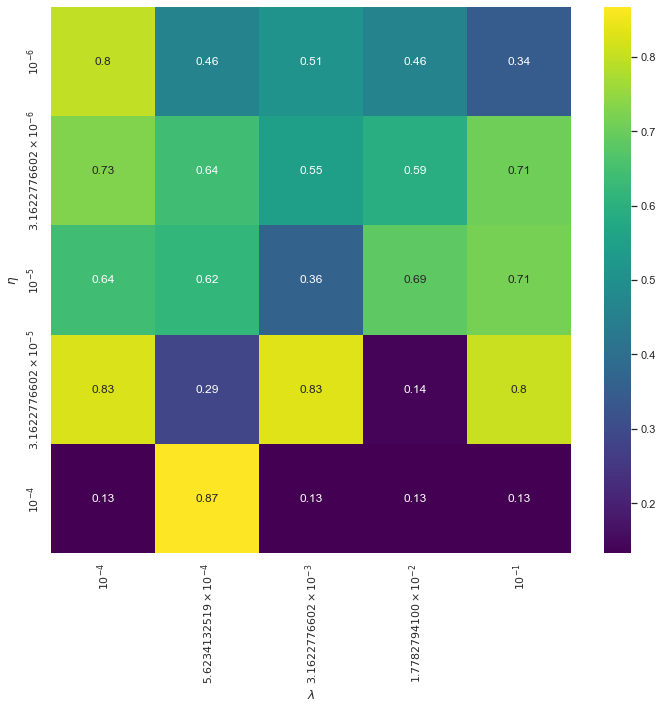

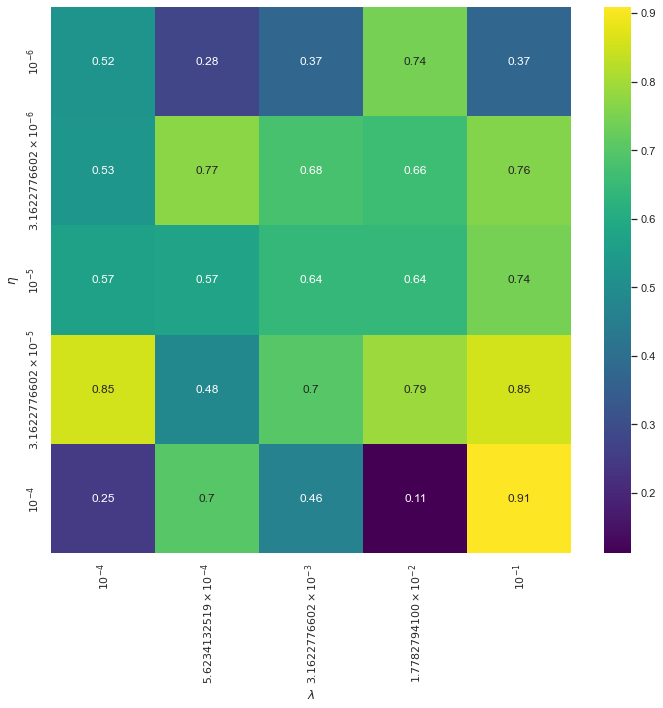

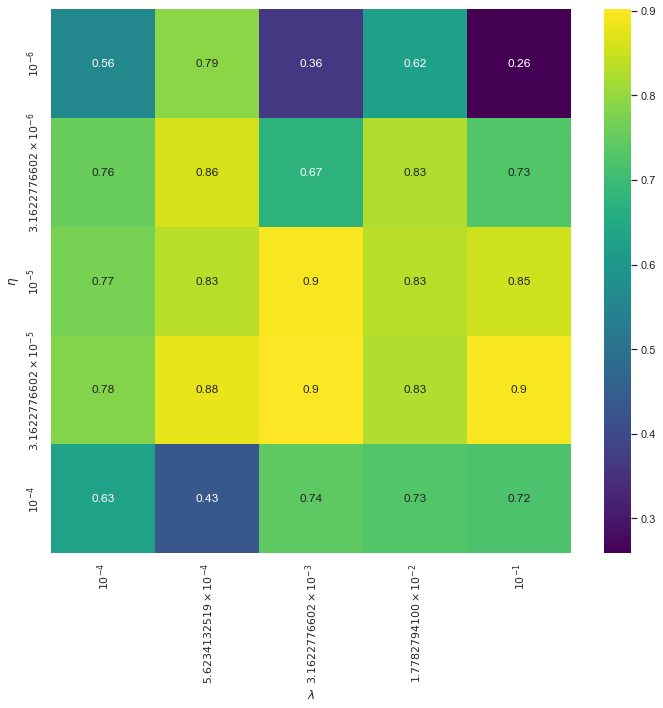

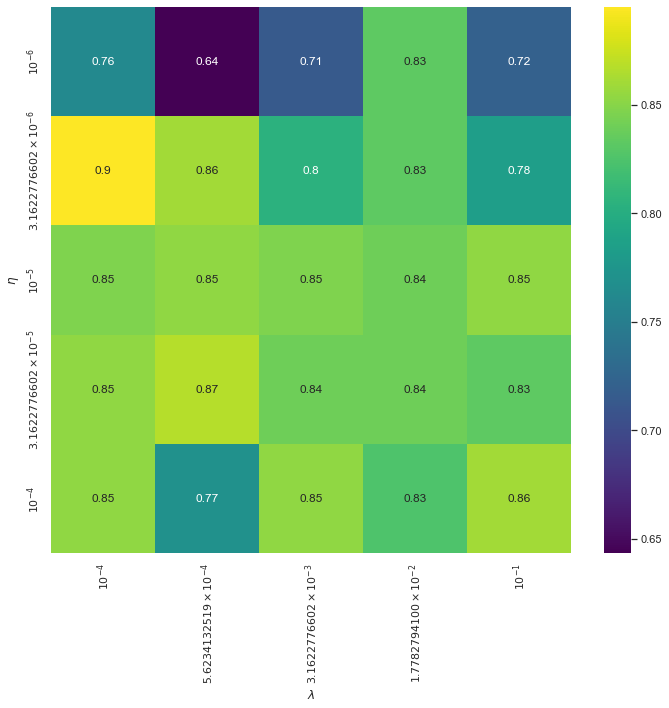

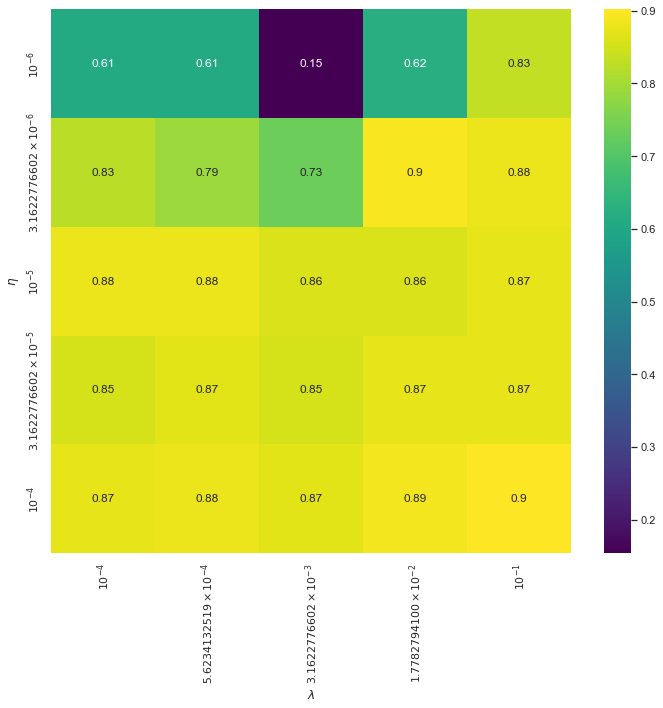

100


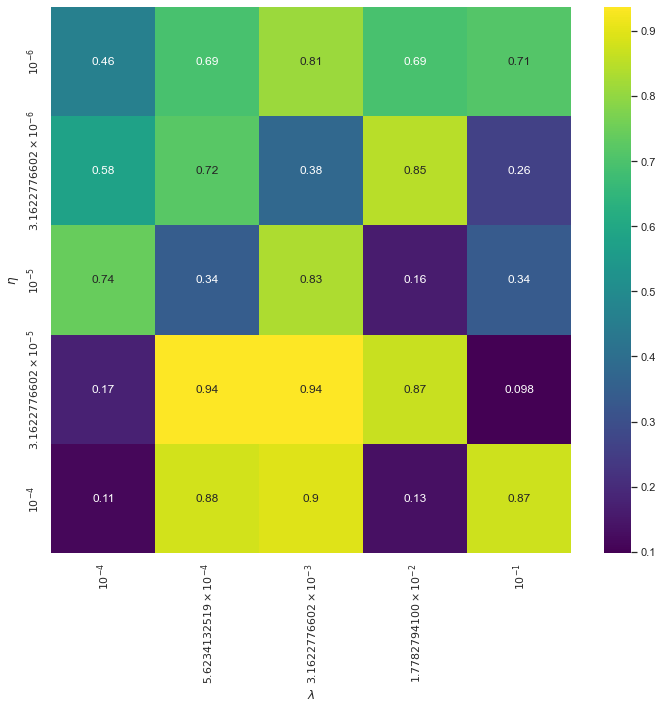

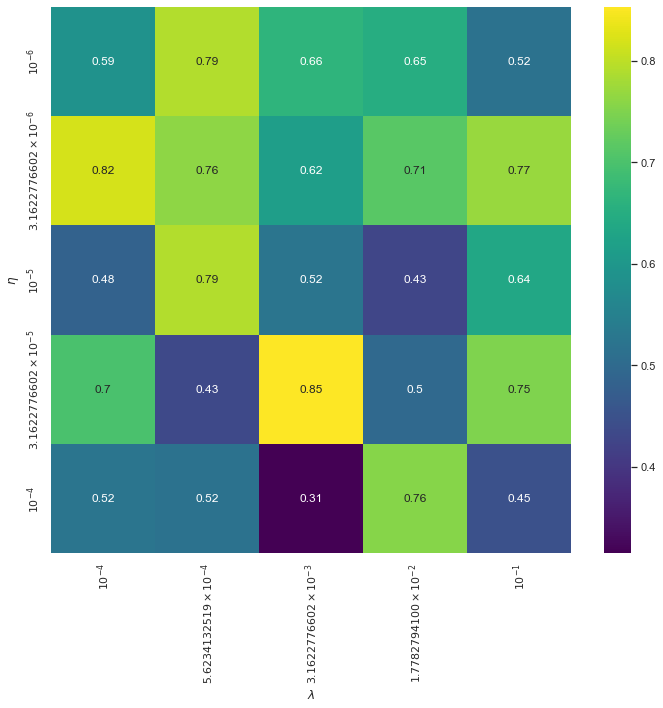

KeyboardInterrupt: 

In [4]:
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)




scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


numberMinibacharray = np.array([4,8,16,32,64])
numEpochsarray = np.array([10,100,1000])
etas = np.logspace(-6,-4,5)
lambdas = np.logspace(-4,-1,5)


for numEpochs in numEpochsarray:
    print(numEpochs)
    
    for numberMinibach in numberMinibacharray:
        accuracy_array = np.zeros((len(etas),len(lambdas)))
        for i,eta in np.ndenumerate(etas):
            
            for j,_lambda in np.ndenumerate(lambdas):
                #print(eta)
                

                weights = StocGradLogic(numberMinibach, numEpochs, X_train_scaled, y_train, eta,_lambda)
                
                
                
                
                #cancer_train_expo = X_train_scaled@weights
                cancer_train_expo = X_test_scaled@weights
                #cancer_train_pred = X_train_scaled@weights
                cancer_train_pred = sigmoid(cancer_train_expo)
                #print(cancer_train_pred.T)
                for n, elem in ndenumerate(cancer_train_pred):
                    if elem<0.5:
                        cancer_train_pred[n] = 0
                    elif elem >=0.5:
                        cancer_train_pred[n] = 1
                #print(weights.T)
                #print(accuracy_score(cancer_train_pred,y_train))
                accuracy_array[i,j] = accuracy_score(cancer_train_pred,y_test)
                #print(cancer_train_pred.T)
                
    
        sns.set()

        #### Sets a log scale on the heat plot
        tick = ticker.ScalarFormatter(useOffset=False, useMathText=True)
        tick.set_powerlimits((0,0))

        tx = [u"${}$".format(tick.format_data(x)) for x in lambdas]
        ty = [u"${}$".format(tick.format_data(x)) for x in etas]

        #lambdas_sea = [lambdas[i] for i in range(len(lambdas))]
        #etas_sea =  [etas[i] for i in range(len(etas))]

        fig, ax = plt.subplots(figsize = (10, 10))
        sns.heatmap(data=accuracy_array,ax=ax, cmap="viridis",annot=True ,xticklabels=tx, yticklabels=ty,)
        ax.set_xlabel(r'$\lambda$')
        ax.set_ylabel(r'$\eta$')
        plt.tight_layout()
        #plt.savefig(f"Ridge_Task_a_adaptive_learn_NumEpochs{numEpochs[epoch_index]}_NumBach{numberMinibach[minibach_index]}_New.pdf")
        plt.show()



"""pred = X_train_scaled@weights
pred = np.rint(pred)
#print(pred)
print(accuracy_score(pred,y_train))"""




In [ ]:
logreg = LogisticRegression()


logreg.fit(X_train, y_train)
print("Train set accuracy from Logistic Regression: {:.2f}".format(logreg.score(X_train,y_train)))
# We scale the data
from sklearn.preprocessing import StandardScaler

# Then perform again a log reg fit
logreg.fit(X_train_scaled, y_train)
print("Train set accuracy scaled data: {:.2f}".format(logreg.score(X_train_scaled,y_train)))
#thereafter we do a PCA with Scikit-learn
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D_train = pca.fit_transform(X_train_scaled)
# and finally compute the log reg fit and the score on the training data
logreg.fit(X2D_train,y_train)
print("Train set accuracy scaled and PCA data: {:.2f}".format(logreg.score(X2D_train,y_train)))

